In [1]:
import data as d

In [2]:
data_list = d.get_data(500, 16, 100, 10)

2422.815
2653.9628


In [3]:
data_list[0][0:50].shape

(50, 16, 10)

In [4]:
seq_batches = []
for l in data_list:
    seq_samples = []
    for i in range(10):
        seq_samples.append(l[i*50:(i+1)*50])
    seq_batches.append(seq_samples)

In [5]:
seq_batches[0][0].shape

(50, 16, 10)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import model_gru as m

In [10]:
torch.cuda.set_device(0)

device = torch.device("cuda")

encoder_l1 = m.SimpleGRUEncoder(50, 250).to(device)
decoder_l1 = m.SimpleGRUDecoder(50, 250).to(device)

encoder_l0 = m.SimpleGRUEncoder(10, 50).to(device)
decoder_l0 = m.SimpleGRUDecoder(10, 50).to(device)

lr=0.001

optimizer_el = optim.Adam(list(encoder_l1.parameters()) + list(encoder_l0.parameters()) , lr=lr)
optimizer_dl1 = optim.Adam(decoder_l1.parameters() , lr=lr)
optimizer_dl0 = optim.Adam(decoder_l0.parameters() , lr=lr)

steps_l1 = 10

loss_fun = nn.MSELoss()



for e in range(500):

    avg_loss = 0.0
    
    for c, b in enumerate(seq_batches):
        encoder_l0.zero_grad()
        encoder_l1.zero_grad()

        decoder_l0.zero_grad()
        decoder_l1.zero_grad()
        
        hidden_states_l0 = []
        
        for s in b:
            hidden_states_l0.append(encoder_l0(torch.from_numpy(s).float().cuda()))
        
        input_l1 = torch.cat(hidden_states_l0, dim=0)
        
        hidden_l1 = encoder_l1(input_l1)
        # print(hidden_l1.shape)
        
        l1_predictions = decoder_l1(hidden_l1, 10)
        
        out_l0 = []
        for i in range(steps_l1):
            out_l0.append(decoder_l0(l1_predictions[i:i+1],s.shape[0]))
        
        out_cat_l0 = torch.cat(out_l0, dim=0)
        
        loss = loss_fun(out_cat_l0, torch.from_numpy(data_list[c]).float().cuda())
        loss.backward()
        
        optimizer_el.step()
        optimizer_dl1.step()
        optimizer_dl0.step()
        
        avg_loss += loss
        
    avg_loss /= len(seq_batches)
    
    print(e, avg_loss)


0 tensor(0.0714, device='cuda:0', grad_fn=<DivBackward0>)
1 tensor(0.0696, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [40]:
#torch.save(encoder_l1, "models/encoder-h50-f50-s1600-b10-lin-adam-el1.mdl")
#torch.save(encoder_l0, "models/encoder-h50-f50-s1600-b10-lin-adam-el0.mdl")
#torch.save(decoder_l1, "models/decoder-h50-f50-s1600-b10-lin-adam-dl1.mdl")
#torch.save(decoder_l0, "models/decoder-h50-f50-s1600-b10-lin-adam-dl0.mdl")

In [125]:
import matplotlib.pyplot as plt

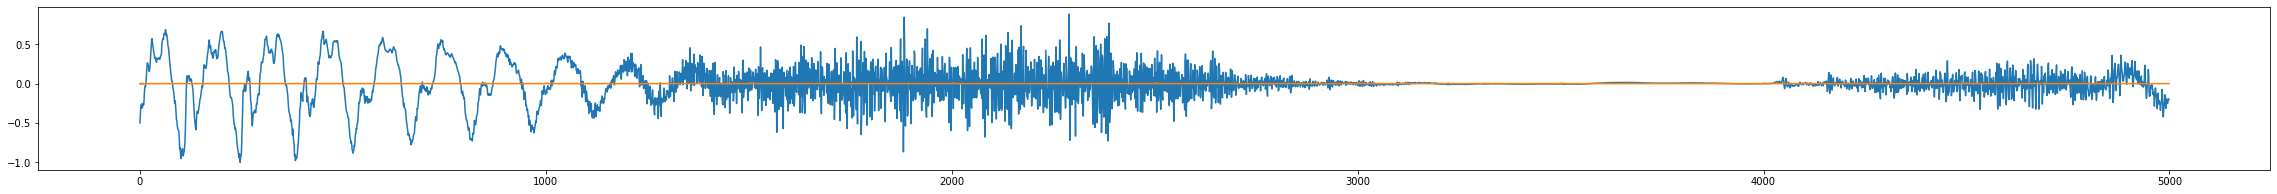

In [127]:
idx = 11
plt.plot(data_list[c][:,idx,:].reshape((-1,)))
plt.plot(out_cat_l0[:,idx,:].cpu().detach().numpy().reshape((-1,)))
plt.rcParams["figure.figsize"] = (40,3)

In [9]:
len(list(encoder_l1.parameters()) + list(encoder_l0.parameters()))

12

In [120]:
import tree_net
import imp
imp.reload(tree_net)

<module 'tree_net' from 'C:\\Users\\Hendrik\\Documents\\GitHub\\ModelTreeGRU\\tree_net.py'>

In [121]:
tn = tree_net.TreeNet([50, 250], 10, [50, 10], 0.01)
data_list[0].shape

(500, 16, 10)

In [122]:
result = tn.forward(torch.from_numpy(data_list[0]).float().cuda())

In [123]:
tn.backward(result, level=1).shape

torch.Size([500, 16, 10])

In [113]:
data_list[0].shape

(500, 16, 10)